In [1]:
import sas7bdat
from sas7bdat import *
import pandas as pd
import numpy as np
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Flatten, Conv2D, MaxPooling1D,BatchNormalization
from keras.layers import Dropout
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.initializers import *
from keras.optimizers import *
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.utils import resample
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import os
from sklearn.dummy import DummyClassifier
os.environ["KMP_DUPLICATE_LIB_OK"]="True"

Using TensorFlow backend.


In [2]:
#converting sas format data into readable csv using dataframe(ovarian)
foo = SAS7BDAT('OvaryData/ovar_data_feb16_d080516.sas7bdat')
primary_data = foo.to_data_frame()

[ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192
W0714 21:02:41.033125 139639586952960 sas7bdat.py:1335] [ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192


foo = SAS7BDAT('OvaryData/screeno_data_feb16_d080516.sas7bdat')
screen_data = foo.to_data_frame()

In [3]:
ovarian_data=primary_data

In [4]:
ovarian_data = ovarian_data.reindex(sorted(ovarian_data.columns), axis=1)

In [5]:
#dcf_dthosumm column is silmilar to f_dthosumm(remember death certificate and death review,hence drop the previous)
ovarian_data=ovarian_data.drop(['age','bmi_curr','bq_compdays','breast_fh_age','dcf_dthosumm','sex',
                                'dcf_unddeath',
                                'f_unddeath','build','dcf_cancersite','rsmoker_f',
                                'is_dead','pack_years','dth_days','dth_cat','f_unddeath_ccode','f_codeath_cat',
                                'dcf_codeath_cat','smoked_f','smokea_f','ssmokea_f',
                                'dcf_unddeath_ccode','mortality_exitstat','mortality_exitage',
                                'mortality_exitdays','inci_last_contact_stat','inci_last_contact_days'
                               ,'ovar_exitstat','fstcan_exitstat','cigar',
                               'weight_f','weight20_f','weight50_f','ibup',
                               'menstrs_stat_type','curative_chemoosumm',
                                'curative_surgosumm','osumm_pathstage','confirmed_osumm','ovar_exitage',
                                'ovar_exitdays',
                                'fstcan_exitage','fstcan_exitdays','cstatusosumm_cat','breast_fh_cnt',
                                'mortality_exitdays','f_dthosumm',
                               'osumm_is_first_dx','osumm_stage'
                               ,'reasothosumm','reassymposumm','osumm_histtype','reassurvosumm','reasfollosumm',
                               'osumm_grade'],axis=1)

#column names after the merging

In [6]:
#rename the columns for readability
ovarian_data=ovarian_data.rename(columns={'f_cancersite':'death_ovarian_Cancer','hasdeo0': 'Diagnostic_Evaluation1',
'hasdeo1': 'Diagnostic_Evaluation2','hasdeo2': 'Diagnostic_Evaluation3','hasdeo3': 'Diagnostic_Evaluation4','hasdeo4': 'Diagnostic_Evaluation5',
'hasdeo5': 'Diagnostic_Evaluation6','biopolink0': 'Biopsy1','biopolink1': 'Biopsy2','biopolink2': 'Biopsy3','biopolink3': 'Biopsy4','biopolink4': 'Biopsy5',
'biopolink5': 'Biopsy6','cstatusosumm_cat': 'current_cancer_status',
'confirmed_osumm':'confirmed_ovarian_cancer',
'tvu_result0': 'transvaginal screening1','tvu_result1': 'transvaginal screening2',
'tvu_result2': 'transvaginal screening3','ca125_src0': 'ca125_test_version1',
'ca125_src1': 'ca125_test_version2','ca125_src2': 'ca125_test_version3','ca125_src3': 'ca125_test_version4',
'ca125_src4': 'ca125_test_version5','ca125_src5': 'ca125_test_version6','orem_fyro': 'ovaries_removed(yr/both)'})

In [7]:
def processCancerpriorTrial(columns):
    if(columns[0]==9):
        return -2
    elif(columns[0]==1):
        return 1
    else:
        return 0

In [8]:
ovarian_data['trial_ph_any']=ovarian_data[['trial_ph_any']].apply(processCancerpriorTrial,axis=1)

In [9]:
#columns to fill the NAN value wth -2

columns=['educat','marital','occupat','pipe','sisters','brothers','cig_stat',
        'fmenstr','menstrs','tubal','tuballig','bbd','benign_ovcyst','endometriosis','uterine_fib','mammo_history',
        'papsmear_history','pelvic_history','usound_history','bq_adminm','trypreg','livec',
        'fchilda','hystera','asppd','ibuppd','bcontra','bcontrt','hyperten_f','hearta_f','stroke_f','emphys_f',
        'bronchit_f','diabetes_f','polyps_f','arthrit_f','osteopor_f','divertic_f','gallblad_f','hispanic_f',
        'hyster_f','ovariesr_f','bcontr_f','horm_stat',
        'cigpd_f','filtered_f','cig_stop','cig_years','bmi_20','bmi_50',
        'bmi_curc','ca125_history','post_menopausal',
        'state','colon_comorbidity','liver_comorbidity','fh_cancer','breast_fh','ovarsumm_fh',
        'bq_cohort_entrydays','nrf_reason','nrf_days',
       'breast_fh','tvu_days0','tvu_days1','tvu_days2','tvu_days3','ca125_days0','ca125_days1',
         'ca125_days2','ca125_days3',
         'ca125_days4','ca125_days5','ovaries_removed(yr/both)','ca125_prot',
        'ca125_test_version1','ca125_test_version2','ca125_test_version3','ca125_test_version4','ca125_test_version5'
         ,'ca125_test_version6',
       'transvaginal screening1','transvaginal screening2','transvaginal screening3','tvu_result3','ca125_result0',
         'ca125_result1','ca125_result2','ca125_result3','ca125_result4','ca125_result5',
        'miscar','death_ovarian_Cancer','ca125_level0','ca125_level1',
                                'ca125_level2','ca125_level3','ca125_level4','ca125_level5',
        'ca125ii_level0','ca125ii_level1','ca125ii_level2','ca125ii_level3','ca125ii_level4','ca125ii_level5'
        ,'osumm_pathstage_m','osumm_pathstage_n','osumm_pathstage_t',
                               'osumm_stage_m','osumm_stage_n','osumm_stage_t','primary_trtosumm',
         'primary_trtosumm_days','ovarsumm_fh_cnt','ovarsumm_fh_age','asp','curhorm','horm_f'
        ,'prega','pregc','preg_f','stillb']

In [10]:
ovarian_data[columns]=ovarian_data[columns].fillna(value=-2.0)

In [11]:
def processFamilyBreasthistory(columns):
    if(columns[0]==0 or columns[0]==2):
        return 0
    elif(columns[0]==1 or columns[0]==9):
        return 1

In [12]:
ovarian_data['breast_fh']=ovarian_data[['breast_fh']].apply(processFamilyBreasthistory,axis=1)

In [13]:
def processRace(columns):
    if(columns[0]==7):
        return -2
    return columns[0]

In [14]:
ovarian_data['race7']=ovarian_data[['race7']].apply(processRace,axis=1)

In [15]:
def processFamilyOvarianhistory(columns):
    if(columns[0]==9):
        return 1
    return columns[0]

In [16]:
ovarian_data['ovarsumm_fh']=ovarian_data[['ovarsumm_fh']].apply(processFamilyOvarianhistory,axis=1)

In [17]:
ovarian_data=ovarian_data.rename(columns={'death_ovarian_Cancer':'output'})

In [18]:
#fill NAN with mean values
#ca125ii

columns=['bq_age','bq_cohort_entryage','height_f']
ovarian_data[columns] = ovarian_data[columns].fillna((ovarian_data[columns].mean()))

ovarian_data['thorm'] =ovarian_data['thorm'].fillna(value=0.0) 

In [19]:
pd.set_option('display.max_rows', None)
ovarian_data.isna().sum()

agelevel                        0
arm                             0
arthrit_f                       0
asp                             0
asppd                           0
bbd                             0
bcontr_f                        0
bcontra                         0
bcontrt                         0
benign_ovcyst                   0
Biopsy1                         0
Biopsy2                         0
Biopsy3                         0
Biopsy4                         0
Biopsy5                         0
Biopsy6                         0
bmi_20                          0
bmi_50                          0
bmi_curc                        0
bq_adminm                       0
bq_age                          0
bq_cohort_entryage              0
bq_cohort_entrydays             0
bq_returned                     0
breast_fh                    2612
bronchit_f                      0
brothers                        0
ca125_days0                     0
ca125_days1                     0
ca125_days2   

In [20]:
ovarian_data.fillna(-2,inplace=True)

In [21]:
ovarian_data = ovarian_data[ovarian_data.cancerosumm != 0.0]

In [22]:
ovarian_data['cancerosumm'].value_counts()

1.0    419
2.0     63
3.0     33
4.0     30
5.0      2
6.0      1
Name: cancerosumm, dtype: int64

In [23]:
def processOutput(columns):
    if(columns[0]==-2.0):
        return 0
    elif(columns[0]==4.0):
        return 1
    return columns[0]

In [24]:
ovarian_data['output']=ovarian_data[['output']].apply(processOutput,axis=1)

In [25]:
ovarian_data['output'].value_counts()

1.0     262
0.0     256
99.0      9
98.0      9
18.0      3
11.0      3
15.0      2
14.0      1
16.0      1
20.0      1
23.0      1
Name: output, dtype: int64

In [26]:
ovarian_data = ovarian_data[ovarian_data.output < 2.0]

In [27]:
ovarian_data['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

columns=['ovar_days','ca125_date','ca125i_assess_days','ca125ii_assess_days',
        'examinerid','examinerid_pvis1','examinerid_pvis2','examinerid_pvis3',
        'examinerid_qvis1','examinerid_qvis2','examinerid_qvis3','physid',
        'ca125_days','ca125_level','ca125_result','ca125_result','ca125_src',
        'tvu_days','tvu_result','build']

screen_data=screen_data.drop(columns,axis=1)

columns=['tvudays_pvis1','tvudays_pvis2','tvudays_pvis3','tvures_pvis1','tvures_pvis2','tvures_pvis3',
         'tvures_qvis1','tvures_qvis2','tvures_qvis3','tvu_assess_days_q','tvu_ref',
         'ovary_diam','ovary_vol','ovcyst_diam','ovcyst_morph','ovcyst_outline','ovcyst_solid',
         'ovcyst_sum','ovcyst_vol','detl_p','detl_q','detr_p','detr_q','lantero_p','lantero_q',
         'llong_p','llong_q','ltran_p','ltran_q','lvol_p','lvol_q','rantero_p','rantero_q',
         'rlong_p','rlong_q','rtran_p','rtran_q','rvol_p','rvol_q','ovary_diaml','ovary_diamr',
         'ovary_voll','ovary_volr','ovcyst_diaml','ovcyst_diamr','ovcyst_outlinel','ovcyst_outliner',
         'ovcyst_solidl','ovcyst_solidr','ovcyst_voll','ovcyst_volr',
         
         'inad_bow','inad_dis','inad_mal',
         'inad_oth','inad_probe','inad_ref','medcomp','QAMETHOD',
         
         'inad_bow_p1','inad_bow_p2','inad_bow_p3',
         'inad_bow_q1','inad_bow_q2','inad_bow_q3',
         'inad_dis_p1','inad_dis_p2','inad_dis_p3',
         
         'inad_dis_q1','inad_dis_q2','inad_dis_q3',
         'inad_mal_p1','inad_mal_p2','inad_mal_p3',
         'inad_mal_q1','inad_mal_q2','inad_mal_q3',
         'inad_oth_p1','inad_oth_p2','inad_oth_p3',
         'inad_oth_q1','inad_oth_q2','inad_oth_q3',
         'inad_probe_p1','inad_probe_p2','inad_probe_p3',
         'inad_probe_q1','inad_probe_q2','inad_probe_q3',
         'inad_ref_q1','inad_ref_q2','inad_ref_q3',
         'inad_ref_p1','inad_ref_p2','inad_ref_p3',
         'phycons']

screen_data[columns]=screen_data[columns].fillna(value=-2.0)

screen_data['QAMETHOD'].value_counts()

screen_data['ovar_result'].value_counts()

screen_data_new = pd.DataFrame(columns=list(screen_data))

n=0
for i in range (len(ovarian_data)):
    selected_rows=screen_data.loc[screen_data['plco_id'] == ovarian_data.iloc[i]['plco_id']]
    selected_rows= selected_rows.sort_values(by=['study_yr'])
    if not selected_rows.empty:
        found=False
        for j in range (len(selected_rows)):
            if selected_rows.iloc[j]['ovar_result']==2 or selected_rows.iloc[j]['ovar_result']==3:
                found=True
                screen_data_new=screen_data_new.append(selected_rows.iloc[j],ignore_index=True)
                break
        if not found:
            screen_data_new=screen_data_new.append(selected_rows.iloc[0],ignore_index=True)
    else:
        n+=1
print(n)

screen_data_new.info()

ovarian_data_new=ovarian_data.merge(screen_data_new,how='left')

In [28]:
ovarian_data_new=ovarian_data.dropna()

In [29]:
ovarian_data_new['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

In [30]:
ovarian_data_new=ovarian_data_new.drop('plco_id',axis=1)

In [31]:
dataOutput=pd.DataFrame(ovarian_data_new['output'])

# using a dummy classifier to understand the imbalance 

#Separate input features and target
y = ovarian_data.output
X = ovarian_data.drop('output', axis=1)

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

#DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

 checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

#checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

trainingData_X, testingData_X, trainingData_Y, testingData_Y = train_test_split(ovarian_data_new,
                                                                                dataOutput,
                                                                                test_size = 0.2)

trainingData_X, validation_X, trainingData_Y, validation_Y = train_test_split(trainingData_X,
                                                                                trainingData_Y,
                                                                                test_size = 0.1)

trainingData_Y['output'].value_counts()

testingData_Y['output'].value_counts()

### Separate majority and minority classes
ovarian_data_majority = trainingData_X[trainingData_X.output==0.0]
ovarian_data_minority = trainingData_X[trainingData_X.output==1.0]

 
### Upsample minority class
ovarian_data_minority_upsampled = resample(ovarian_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results

   
ovarian_data_majority_upsampled = resample(ovarian_data_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results

#### Combine majority class with upsampled minority class
ovarian_data_upsampled = pd.concat([ovarian_data_minority_upsampled,
                                    ovarian_data_majority_upsampled,
                                    ovarian_data_majority
                                   ,ovarian_data_minority])

ovarian_data_upsampled=ovarian_data_upsampled.sample(frac=1).reset_index(drop=True)

#### Display new class counts
ovarian_data_upsampled.output.value_counts()

trainingData_X=ovarian_data_upsampled
trainingData_Y = ovarian_data_upsampled['output']

In [32]:
#trainingData_X = trainingData_X.drop(['output'],axis=1)
#testingData_X = testingData_X.drop(['output'],axis=1)
#validation_X = validation_X.drop(['output'],axis=1)
ovarian_data_new=ovarian_data_new.drop(['output'],axis=1)

In [33]:
scaler = pre.MinMaxScaler(feature_range=(0,1))
#intermediate=scaler.fit(ovarian_data_new.values)

In [34]:
def apply_smote(X_Train,Y_Train):
    
    smt=SMOTE()
    X_new=np.concatenate((X_Train,Y_Train),axis=1)

    not_dead=X_new[X_new[:,-1]==0]
    dead=X_new[X_new[:,-1]==1]

    not_dead_new=resample(not_dead,replace=True,n_samples=2000,random_state=123)
    dead_new=resample(dead,replace=True,n_samples=2000,random_state=123)

    x_train_new=np.concatenate((not_dead_new,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]

    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)
    y_train_new=y_train_new.reshape(y_train_new.shape[0],1)
    X_new=np.concatenate((x_train_new,y_train_new),axis=1)
    dead=X_new[X_new[:,-1]==1]

    x_train_new=np.concatenate((not_dead,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]
    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)

    x_train=x_train_new
    y_train=y_train_new
    

    x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    

    return x_train,y_train
    

In [35]:
def get_model(x_train):

    model=Sequential()
    model.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='relu',
                                 kernel_initializer='lecun_normal')))
    model.add(MaxPooling1D(2))
    model.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='lecun_normal',
                                  kernel_regularizer=regularizers.l2(0.01))))
    model.add(MaxPooling1D(2))
    model.add((LocallyConnected1D(4, 4,activation='selu',kernel_initializer='lecun_normal'
                                  ,kernel_regularizer=regularizers.l2(0.01))))
    model.add(MaxPooling1D(2))

    model.add(Flatten())
    model.add(Dense(128,activation='elu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(16,activation='selu',kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(8,activation='relu',kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))


    
    model.compile(loss='categorical_hinge', optimizer=Nadam(lr=0.00001),metrics=['accuracy'])
    
    model.summary()
    
    
    return model

x_train=trainingData_X.values
x_train=intermediate.transform(x_train)

x_test=testingData_X.values
x_test=intermediate.transform(x_test)

x_valid=validation_X.values
x_valid=intermediate.transform(x_valid)

y_train=trainingData_Y.values
y_test=testingData_Y.values
#y_valid=validation_Y.values

Start Stratified K-Fold Training for learning rate 0.000015
This is the entire training of 1 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_31 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_32 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_33 (Loca (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 17, 4)             0         
___________________________

4000/4000 [==============================] - 3s 774us/step - loss: 0.9062 - acc: 0.8097 - val_loss: 0.9529 - val_acc: 0.7547
Epoch 99/150
4000/4000 [==============================] - 2s 550us/step - loss: 0.8978 - acc: 0.8070 - val_loss: 0.9463 - val_acc: 0.7358
Epoch 100/150
4000/4000 [==============================] - 2s 541us/step - loss: 0.8881 - acc: 0.8118 - val_loss: 0.9372 - val_acc: 0.7547
Epoch 101/150
4000/4000 [==============================] - 2s 551us/step - loss: 0.8790 - acc: 0.8123 - val_loss: 0.9273 - val_acc: 0.7358
Epoch 102/150
4000/4000 [==============================] - 3s 637us/step - loss: 0.8683 - acc: 0.8110 - val_loss: 0.9243 - val_acc: 0.7358
Epoch 103/150
4000/4000 [==============================] - 2s 557us/step - loss: 0.8656 - acc: 0.8143 - val_loss: 0.9154 - val_acc: 0.7358
Epoch 104/150
4000/4000 [==============================] - 2s 555us/step - loss: 0.8527 - acc: 0.8200 - val_loss: 0.9105 - val_acc: 0.7170
Epoch 105/150
4000/4000 [=================

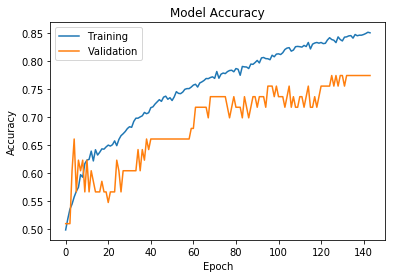

Loss Curve:


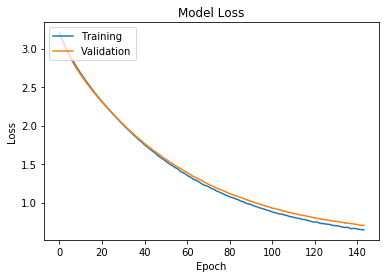

Confusion Matrix
           Pred: yes  Pred: no
True: yes         19         7
True: no           5        22
precision_score: 0.7586206896551724 specificity_score: 0.7307692307692307 recall_score: 0.8148148148148148
f1_score 0.7857142857142857
This is the entire training of 2 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_34 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_35 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_36 (Loca (None, 34, 

4000/4000 [==============================] - 2s 515us/step - loss: 0.8691 - acc: 0.8323 - val_loss: 1.0056 - val_acc: 0.7547
Epoch 98/150
4000/4000 [==============================] - 2s 471us/step - loss: 0.8632 - acc: 0.8357 - val_loss: 0.9967 - val_acc: 0.7547
Epoch 99/150
4000/4000 [==============================] - 2s 476us/step - loss: 0.8509 - acc: 0.8375 - val_loss: 0.9917 - val_acc: 0.7547
Epoch 100/150
4000/4000 [==============================] - 3s 633us/step - loss: 0.8432 - acc: 0.8400 - val_loss: 0.9835 - val_acc: 0.7547
Epoch 101/150
4000/4000 [==============================] - 2s 471us/step - loss: 0.8353 - acc: 0.8405 - val_loss: 0.9789 - val_acc: 0.7547
Epoch 102/150
4000/4000 [==============================] - 2s 471us/step - loss: 0.8292 - acc: 0.8387 - val_loss: 0.9705 - val_acc: 0.7547
Epoch 103/150
4000/4000 [==============================] - 2s 407us/step - loss: 0.8222 - acc: 0.8375 - val_loss: 0.9648 - val_acc: 0.7547
Epoch 104/150
4000/4000 [==================

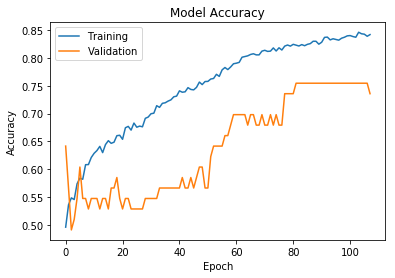

Loss Curve:


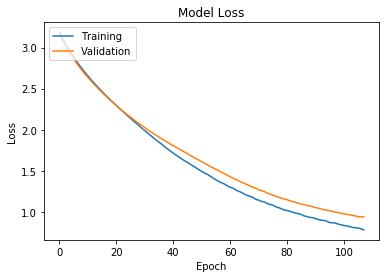

Confusion Matrix
           Pred: yes  Pred: no
True: yes         21         5
True: no           9        18
precision_score: 0.782608695652174 specificity_score: 0.8076923076923077 recall_score: 0.6666666666666666
f1_score 0.72
This is the entire training of 3 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_37 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_38 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_39 (Loca (None, 34, 4)             

4000/4000 [==============================] - 3s 753us/step - loss: 0.8834 - acc: 0.8025 - val_loss: 1.0072 - val_acc: 0.6923
Epoch 98/150
4000/4000 [==============================] - 2s 561us/step - loss: 0.8722 - acc: 0.8028 - val_loss: 1.0021 - val_acc: 0.7115
Epoch 99/150
4000/4000 [==============================] - 2s 550us/step - loss: 0.8594 - acc: 0.8060 - val_loss: 0.9965 - val_acc: 0.7115
Epoch 100/150
4000/4000 [==============================] - 2s 580us/step - loss: 0.8557 - acc: 0.7995 - val_loss: 0.9887 - val_acc: 0.6923
Epoch 101/150
4000/4000 [==============================] - 3s 696us/step - loss: 0.8465 - acc: 0.8113 - val_loss: 0.9826 - val_acc: 0.6923
Epoch 102/150
4000/4000 [==============================] - 2s 563us/step - loss: 0.8434 - acc: 0.8077 - val_loss: 0.9754 - val_acc: 0.6923
Epoch 103/150
4000/4000 [==============================] - 2s 544us/step - loss: 0.8321 - acc: 0.8103 - val_loss: 0.9680 - val_acc: 0.6923
Epoch 104/150
4000/4000 [==================

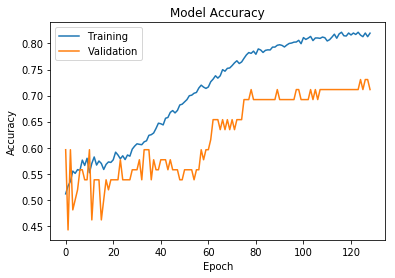

Loss Curve:


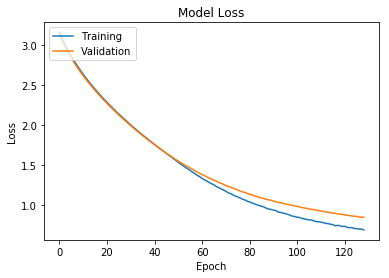

Confusion Matrix
           Pred: yes  Pred: no
True: yes         19         7
True: no           8        18
precision_score: 0.72 specificity_score: 0.7307692307692307 recall_score: 0.6923076923076923
f1_score 0.7058823529411765
This is the entire training of 4 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_40 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_41 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_42 (Loca (None, 34, 4)            

4000/4000 [==============================] - 2s 573us/step - loss: 0.9078 - acc: 0.7708 - val_loss: 0.8275 - val_acc: 0.8462
Epoch 98/150
4000/4000 [==============================] - 2s 620us/step - loss: 0.9032 - acc: 0.7710 - val_loss: 0.8207 - val_acc: 0.8462
Epoch 99/150
4000/4000 [==============================] - 3s 712us/step - loss: 0.8880 - acc: 0.7745 - val_loss: 0.8130 - val_acc: 0.8462
Epoch 100/150
4000/4000 [==============================] - 2s 577us/step - loss: 0.8827 - acc: 0.7722 - val_loss: 0.8065 - val_acc: 0.8462
Epoch 101/150
4000/4000 [==============================] - 2s 578us/step - loss: 0.8777 - acc: 0.7785 - val_loss: 0.8002 - val_acc: 0.8654
Epoch 102/150
4000/4000 [==============================] - 3s 767us/step - loss: 0.8666 - acc: 0.7740 - val_loss: 0.7940 - val_acc: 0.8462
Epoch 103/150
4000/4000 [==============================] - 2s 568us/step - loss: 0.8580 - acc: 0.7777 - val_loss: 0.7883 - val_acc: 0.8462
Epoch 104/150
4000/4000 [==================

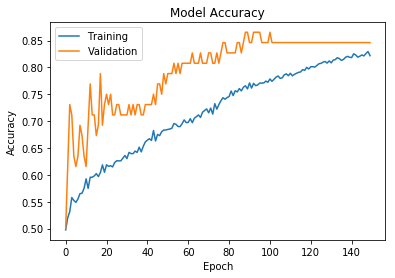

Loss Curve:


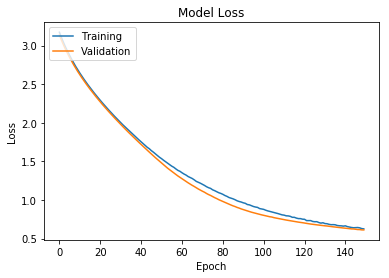

Confusion Matrix
           Pred: yes  Pred: no
True: yes         22         4
True: no           4        22
precision_score: 0.8461538461538461 specificity_score: 0.8461538461538461 recall_score: 0.8461538461538461
f1_score 0.8461538461538461
This is the entire training of 5 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_43 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_44 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_45 (Loca (None, 34, 

4000/4000 [==============================] - 2s 476us/step - loss: 0.9031 - acc: 0.8155 - val_loss: 0.9515 - val_acc: 0.7500
Epoch 98/150
4000/4000 [==============================] - 2s 486us/step - loss: 0.8897 - acc: 0.8180 - val_loss: 0.9507 - val_acc: 0.7115
Epoch 99/150
4000/4000 [==============================] - 3s 776us/step - loss: 0.8801 - acc: 0.8220 - val_loss: 0.9450 - val_acc: 0.7115
Epoch 100/150
4000/4000 [==============================] - 3s 652us/step - loss: 0.8747 - acc: 0.8275 - val_loss: 0.9359 - val_acc: 0.7115
Epoch 101/150
4000/4000 [==============================] - 2s 483us/step - loss: 0.8685 - acc: 0.8230 - val_loss: 0.9155 - val_acc: 0.7885
Epoch 102/150
4000/4000 [==============================] - 2s 467us/step - loss: 0.8576 - acc: 0.8280 - val_loss: 0.9119 - val_acc: 0.7692
Epoch 103/150
4000/4000 [==============================] - 2s 523us/step - loss: 0.8559 - acc: 0.8245 - val_loss: 0.9050 - val_acc: 0.7885
Epoch 104/150
4000/4000 [==================

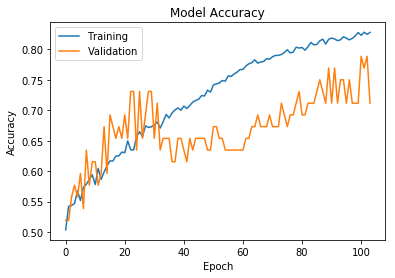

Loss Curve:


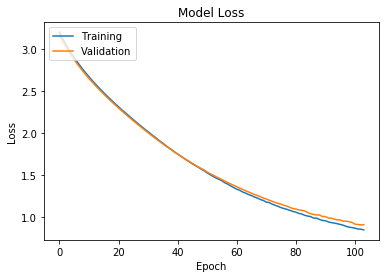

Confusion Matrix
           Pred: yes  Pred: no
True: yes         21         5
True: no          10        16
precision_score: 0.7619047619047619 specificity_score: 0.8076923076923077 recall_score: 0.6153846153846154
f1_score 0.6808510638297872
This is the entire training of 6 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_46 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_47 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_48 (Loca (None, 34, 

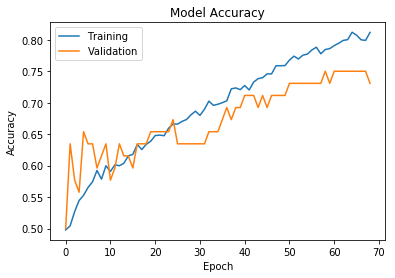

Loss Curve:


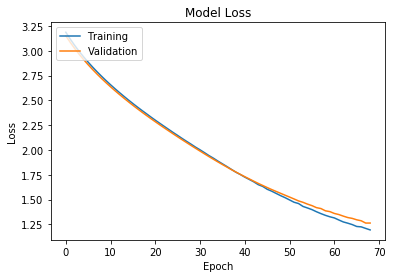

Confusion Matrix
           Pred: yes  Pred: no
True: yes         22         4
True: no          10        16
precision_score: 0.8 specificity_score: 0.8461538461538461 recall_score: 0.6153846153846154
f1_score 0.6956521739130435
This is the entire training of 7 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_49 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_50 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_51 (Loca (None, 34, 4)             

4000/4000 [==============================] - 2s 441us/step - loss: 0.9433 - acc: 0.7055 - val_loss: 0.9962 - val_acc: 0.5882
Epoch 98/150
4000/4000 [==============================] - 2s 392us/step - loss: 0.9345 - acc: 0.7085 - val_loss: 0.9913 - val_acc: 0.5686
Epoch 99/150
4000/4000 [==============================] - 2s 394us/step - loss: 0.9280 - acc: 0.7097 - val_loss: 0.9832 - val_acc: 0.5686
Epoch 100/150
4000/4000 [==============================] - 2s 434us/step - loss: 0.9198 - acc: 0.7070 - val_loss: 0.9760 - val_acc: 0.5686
Epoch 101/150
4000/4000 [==============================] - 2s 392us/step - loss: 0.9090 - acc: 0.7097 - val_loss: 0.9719 - val_acc: 0.5686
Epoch 102/150
4000/4000 [==============================] - 2s 393us/step - loss: 0.9061 - acc: 0.7067 - val_loss: 0.9642 - val_acc: 0.5686
Epoch 103/150
4000/4000 [==============================] - 2s 383us/step - loss: 0.8978 - acc: 0.7145 - val_loss: 0.9587 - val_acc: 0.5686
Epoch 104/150
4000/4000 [==================

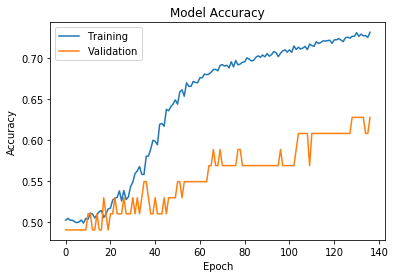

Loss Curve:


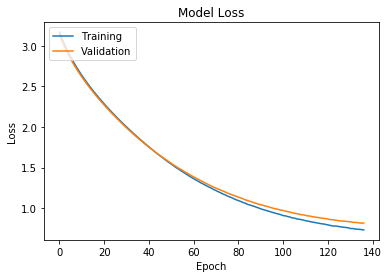

Confusion Matrix
           Pred: yes  Pred: no
True: yes         20         5
True: no          14        12
precision_score: 0.7058823529411765 specificity_score: 0.8 recall_score: 0.46153846153846156
f1_score 0.558139534883721
This is the entire training of 8 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_52 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_53 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_54 (Loca (None, 34, 4)             

4000/4000 [==============================] - 2s 433us/step - loss: 0.9110 - acc: 0.8175 - val_loss: 1.1181 - val_acc: 0.6275
Epoch 98/150
4000/4000 [==============================] - 2s 388us/step - loss: 0.9002 - acc: 0.8145 - val_loss: 1.1114 - val_acc: 0.6471
Epoch 99/150
4000/4000 [==============================] - 2s 389us/step - loss: 0.8908 - acc: 0.8165 - val_loss: 1.1042 - val_acc: 0.6471
Epoch 100/150
4000/4000 [==============================] - 2s 394us/step - loss: 0.8852 - acc: 0.8175 - val_loss: 1.0975 - val_acc: 0.6078
Epoch 101/150
4000/4000 [==============================] - 2s 445us/step - loss: 0.8732 - acc: 0.8195 - val_loss: 1.0921 - val_acc: 0.6275
Epoch 102/150
4000/4000 [==============================] - 2s 387us/step - loss: 0.8736 - acc: 0.8155 - val_loss: 1.0862 - val_acc: 0.6667
Epoch 103/150
4000/4000 [==============================] - 2s 390us/step - loss: 0.8620 - acc: 0.8252 - val_loss: 1.0776 - val_acc: 0.6471
Epoch 104/150
4000/4000 [==================

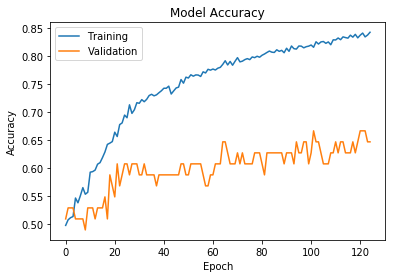

Loss Curve:


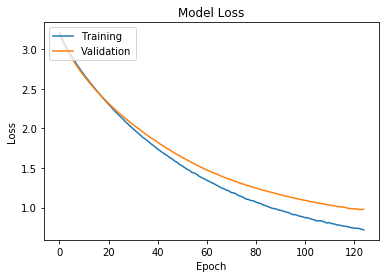

Confusion Matrix
           Pred: yes  Pred: no
True: yes         19         6
True: no          12        14
precision_score: 0.7 specificity_score: 0.76 recall_score: 0.5384615384615384
f1_score 0.608695652173913
This is the entire training of 9 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_55 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_56 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_57 (Loca (None, 34, 4)             8840      
____

4000/4000 [==============================] - 2s 462us/step - loss: 0.8897 - acc: 0.8107 - val_loss: 1.1047 - val_acc: 0.6667
Epoch 98/150
4000/4000 [==============================] - 2s 464us/step - loss: 0.8819 - acc: 0.8175 - val_loss: 1.0980 - val_acc: 0.6471
Epoch 99/150
4000/4000 [==============================] - 4s 876us/step - loss: 0.8711 - acc: 0.8175 - val_loss: 1.0921 - val_acc: 0.6275
Epoch 100/150
4000/4000 [==============================] - 2s 462us/step - loss: 0.8658 - acc: 0.8195 - val_loss: 1.0841 - val_acc: 0.6667
Epoch 101/150
4000/4000 [==============================] - 2s 471us/step - loss: 0.8575 - acc: 0.8203 - val_loss: 1.0786 - val_acc: 0.6667
Epoch 102/150
4000/4000 [==============================] - 2s 470us/step - loss: 0.8483 - acc: 0.8180 - val_loss: 1.0733 - val_acc: 0.6667
Epoch 103/150
4000/4000 [==============================] - 3s 727us/step - loss: 0.8393 - acc: 0.8195 - val_loss: 1.0674 - val_acc: 0.6471
Epoch 104/150
4000/4000 [==================

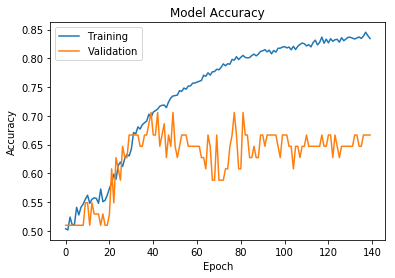

Loss Curve:


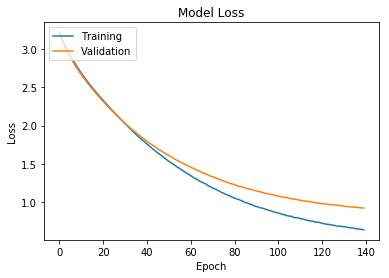

Confusion Matrix
           Pred: yes  Pred: no
True: yes         18         7
True: no          10        16
precision_score: 0.6956521739130435 specificity_score: 0.72 recall_score: 0.6153846153846154
f1_score 0.6530612244897959
This is the entire training of 10 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_58 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_59 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_60 (Loca (None, 34, 4)           

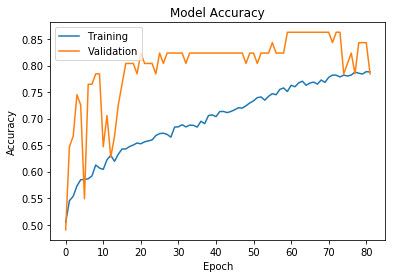

Loss Curve:


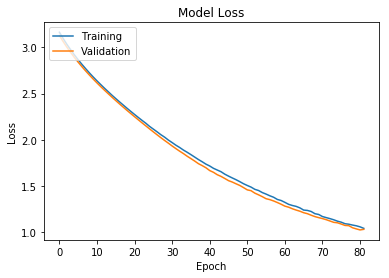

Confusion Matrix
           Pred: yes  Pred: no
True: yes         16         9
True: no           2        24
precision_score: 0.7272727272727273 specificity_score: 0.64 recall_score: 0.9230769230769231
f1_score 0.8135593220338984
The mean of all the accuracies of the models is : 0.72% (+/- 0.06%)
The validation loss and accuracies are: [[0.7053405844940329, 0.7735849135326889], [0.9397590632708568, 0.7358490599776214], [0.8488509379900419, 0.7115384569534888], [0.6114059136464045, 0.8461538507388189], [0.9095470721905048, 0.7115384569534888], [1.2633152466553907, 0.7307692399391761], [0.8185302322986079, 0.627450985067031], [0.9789459004121668, 0.6470588200232562], [0.9238334683810964, 0.666666663160511], [1.0317346254984539, 0.7843137278276331]]


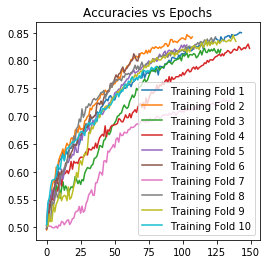

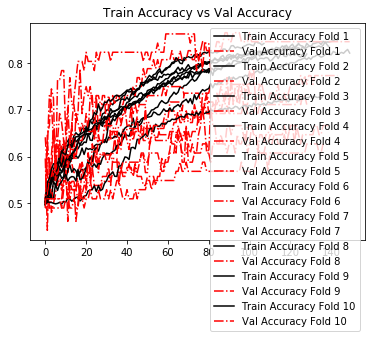

In [37]:
from sklearn.metrics import f1_score

batch_size = 32
epochs = 150
k = 10
result = []
cvscores = []
model_history = []
count = 0
#parameters_array = [0.5,0.7]


#print('Start KFold')
from sklearn.model_selection import KFold,StratifiedKFold
from keras.callbacks import EarlyStopping,ModelCheckpoint
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state = 5)


X = ovarian_data_new.values
X = X.astype('float32')
intermediate = scaler.fit(X)
X = intermediate.transform(X)


Y = dataOutput.values
Y = Y.astype('float32')


print('Start Stratified K-Fold Training for learning rate 0.000015')


#for value in parameters_array:
    #cvscores = []
    #model_history = []
    
    #print('This is the cross validation for the parameter->',value)
    
for train_index, test_index in kf.split(X,Y):
    print("This is the entire training of",(count+1),"fold Cross validation")

    #print("TRAIN:", train_index, "TEST:", test_index)

    X_Train = X[train_index]
    X_Test = X[test_index]

    Y_Train = Y[train_index]
    Y_Test = Y[test_index]

    #print("This is x_train data",X_Train)
    #print("This is y_train data",Y_Train)

    #print(X_Test)
    #print(Y_Test)


    #print("Applying Upsampling and SMOTE")
    x_train, y_train = apply_smote(X_Train,Y_Train)

    #Transforming the data
    x_test=X_Test.reshape(X_Test.shape[0],X_Test.shape[1],1)
    y_test=Y_Test


    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    #Traingin the model
    model = get_model(x_train)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    #mc = ModelCheckpoint('model2_best_model.h5', monitor='loss',verbose=0, save_best_only=True)


    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),callbacks=[es])
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)

    model_history.append(history)

    scores = model.evaluate(x_test, y_test)


    cvscores.append(scores)
    print("Accuracy of the Model(Fold=",(count+1),"is: %.2f%% " % (scores[1]*100))

    print("Accuracy Curve:")
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()


    print("Loss Curve:")

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()


    y_pred = model.predict_classes(x_test)


    y_test_new=[]
    for i in y_test:
        y_test_new.append(np.argmax(i))


    #oof = model.predict_classes(X_valid)

    # Confusion matrix

    print("Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_test_new, y_pred),
                   index=['True: yes', 'True: no'],
                   columns=['Pred: yes', 'Pred: no']))

    tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred).ravel()
    print("precision_score:", tp/(fp + tp), "specificity_score:", tn/(tn+fp), "recall_score:", tp/(fn+tp))
    # F1 score
    print("f1_score", f1_score(y_test_new,y_pred))

    count =  count + 1

print("The mean of all the accuracies of the models is :","%.2f%% (+/- %.2f%%)" % (np.mean([x[1] for x in cvscores]), np.std([x[1] for x in cvscores])))
print('The validation loss and accuracies are:',[x for x in cvscores])



#PLOT TRAINING ACCURACIES VS EPOCHS GRAPHS
plt.figure(figsize=(4,4))
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.plot(model_history[3].history['acc'], label='Training Fold 4')
plt.plot(model_history[4].history['acc'], label='Training Fold 5')
plt.plot(model_history[5].history['acc'], label='Training Fold 6')
plt.plot(model_history[6].history['acc'], label='Training Fold 7')
plt.plot(model_history[7].history['acc'], label='Training Fold 8')
plt.plot(model_history[8].history['acc'], label='Training Fold 9')
plt.plot(model_history[9].history['acc'], label='Training Fold 10')
plt.legend()
plt.show()


plt.title('Train Accuracy vs Val Accuracy')

plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='red', linestyle = "dashdot")

plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='black', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='black', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='red', linestyle = "dashdot")

plt.plot(model_history[3].history['acc'], label='Train Accuracy Fold 4', color='black', )
plt.plot(model_history[3].history['val_acc'], label='Val Accuracy Fold 4', color='red', linestyle = "dashdot")

plt.plot(model_history[4].history['acc'], label='Train Accuracy Fold 5', color='black', )
plt.plot(model_history[4].history['val_acc'], label='Val Accuracy Fold 5', color='red', linestyle = "dashdot")

plt.plot(model_history[5].history['acc'], label='Train Accuracy Fold 6', color='black', )
plt.plot(model_history[5].history['val_acc'], label='Val Accuracy Fold 6', color='red', linestyle = "dashdot")


plt.plot(model_history[6].history['acc'], label='Train Accuracy Fold 7', color='black', )
plt.plot(model_history[6].history['val_acc'], label='Val Accuracy Fold 7', color='red', linestyle = "dashdot")

plt.plot(model_history[7].history['acc'], label='Train Accuracy Fold 8', color='black', )
plt.plot(model_history[7].history['val_acc'], label='Val Accuracy Fold 8', color='red', linestyle = "dashdot")


plt.plot(model_history[8].history['acc'], label='Train Accuracy Fold 9', color='black', )
plt.plot(model_history[8].history['val_acc'], label='Val Accuracy Fold 9', color='red', linestyle = "dashdot")

plt.plot(model_history[9].history['acc'], label='Train Accuracy Fold 10', color='black', )
plt.plot(model_history[9].history['val_acc'], label='Val Accuracy Fold 10', color='red', linestyle = "dashdot")


plt.legend()
plt.show()


import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = pd.DataFrame(ovarian_data_upsampled.corr())

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/proco_data_feb16_d080516.sas7bdat')
diagnostic_procedure_data = foo.to_data_frame()

len(diagnostic_procedure_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/medo_data_feb16_d080516.sas7bdat')
medical_complication_data = foo.to_data_frame()

len(medical_complication_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/screeno_data_feb16_d080516.sas7bdat')
screening_data = foo.to_data_frame()

len(screening_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/scrsubo_data_feb16_d080516.sas7bdat')
screening_abnormality_data = foo.to_data_frame()

len(screening_abnormality_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/trt_o_data_feb16_d080516.sas7bdat')
treatment_data = foo.to_data_frame()

len(treatment_data)